In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('Perrin Freres monthly champagne sales millions.csv')

In [4]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [5]:
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [6]:
df.drop(106,axis=0,inplace=True)

In [7]:
df.drop(105,axis=0,inplace=True)

In [8]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [9]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [10]:
df.set_index('Month',inplace=True)

In [11]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [12]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<Axes: xlabel='Month'>

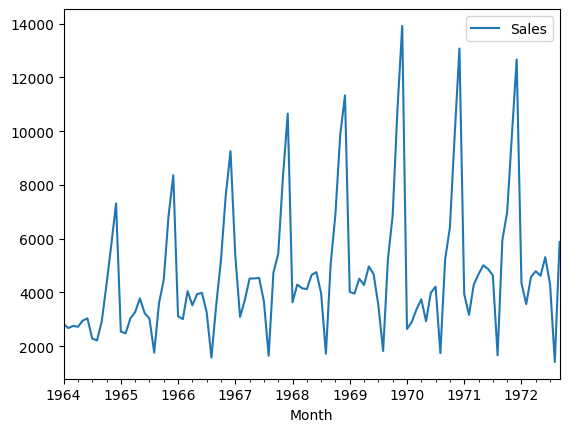

In [13]:
df.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
test_result=adfuller(df['Sales'])

In [16]:
def adfuller_test(sales):
    
    result=adfuller(sales)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276195
p-value : 0.3639157716602467
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [18]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [19]:
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

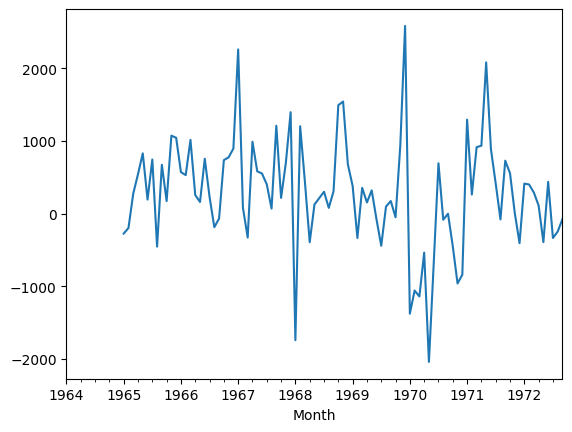

In [20]:
df['Seasonal First Difference'].plot()

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

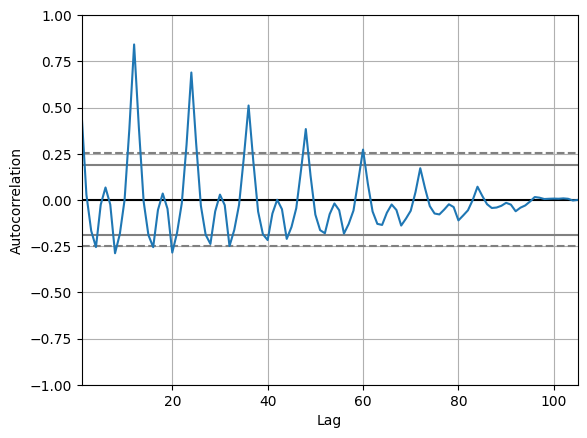

In [22]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


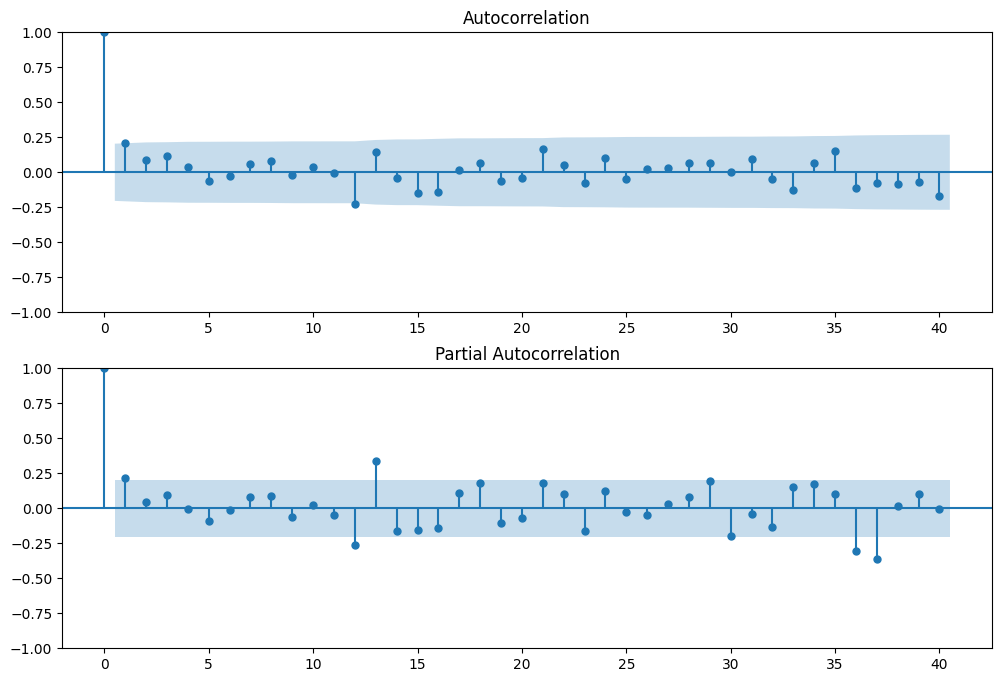

In [23]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [24]:
from pmdarima import auto_arima


In [34]:
trend ='n'
model = auto_arima(df['Sales'] , seasonal=True, suppress_warnings=True,
                   trend= trend, enforce_stationarity=False, enforce_invertibility=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -949.431
Date:                Sat, 15 Apr 2023   AIC                           1904.863
Time:                        21:08:35   BIC                           1912.796
Sample:                    01-01-1964   HQIC                          1908.076
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3308      0.072     -4.614      0.000      -0.471      -0.190
ma.L2         -0.6027      0.090     -6.665      0.000      -0.780      -0.425
sigma2      4.885e+06   6.35e+05      7.690      0.0

In [26]:
import statsmodels.api as sm

In [35]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(0, 1, 2),seasonal_order=(0,1,2,12), trend ='n')
results=model.fit()

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<Axes: xlabel='Month'>

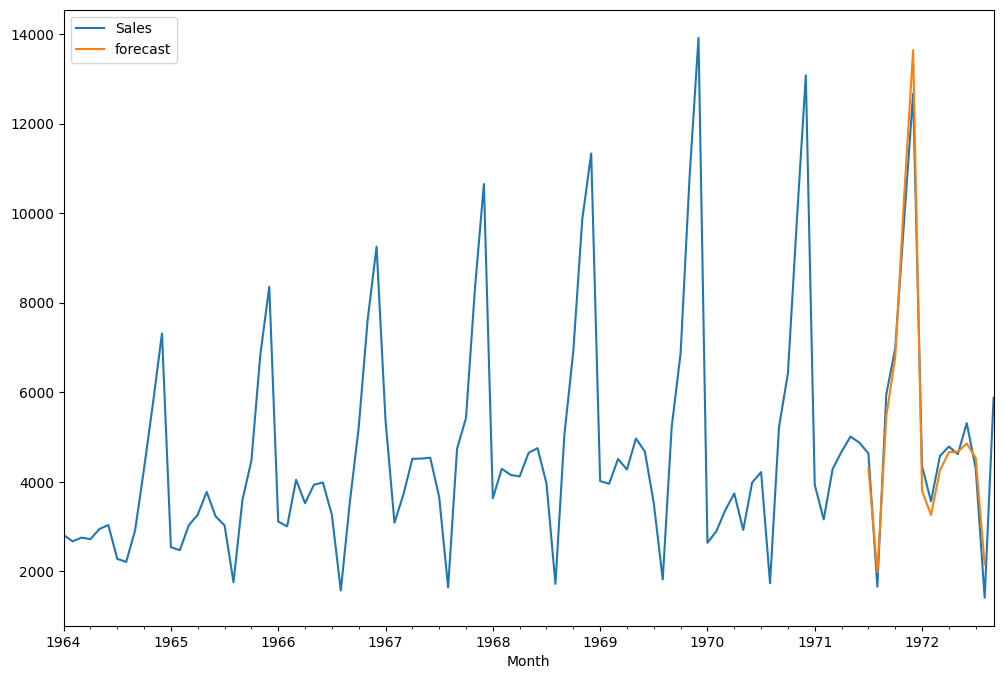

In [36]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))
 

In [27]:
from pandas.tseries.offsets import DateOffset

#Here USING FOR LOOP we are adding some additional data for prediction purpose:

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [28]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [29]:
future_datest_df.tail()

,Sales,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


In [30]:
future_df=pd.concat([df,future_datest_df])

<Axes: >

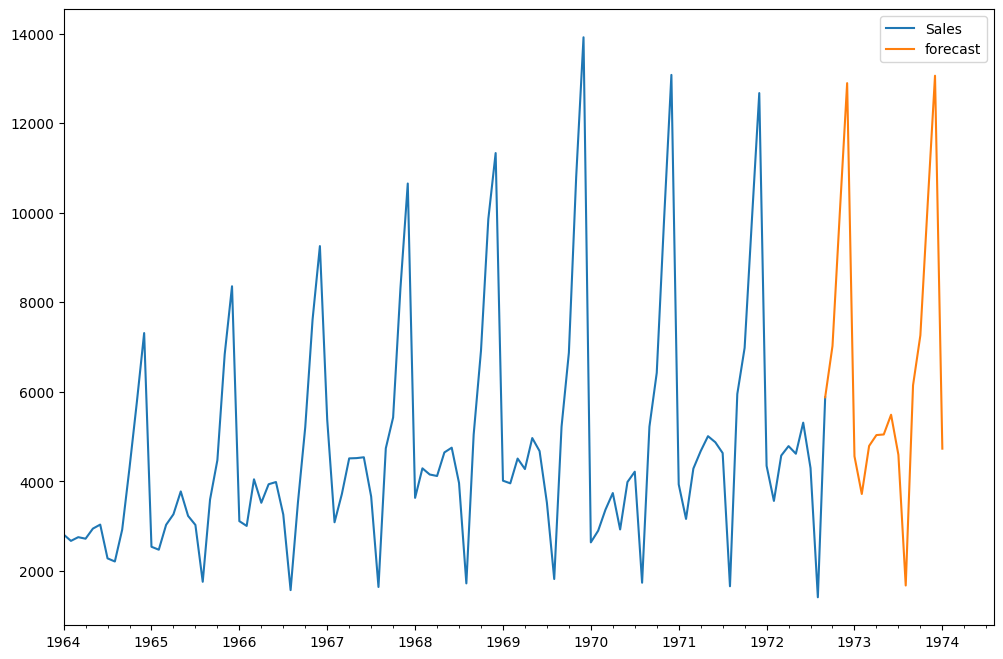

In [31]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))